# PV output from ERA5-land for one coordinate

In [153]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
This script creates an array containing energy in kWh
for a certain PV size based on ERA5-land data in a single coordinate

Created on Monday July  29 14:17:50 2019

@author: luis@refuel
"""

import xarray as xr
import pvlib
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import pvlib
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#define the data sets that are going to be used
input_era5l_data = "/home/lramirez/my-data/ERA5_land_data/derived/era5l_2001_01.nc"
#load the data set
era5 = xr.open_dataset(input_era5l_data, chunks={'lon': 10, 'lat':10})
#define the coordinates and the time series that will be assessed
start_time = "2001-01-01T01:00:00"
end_time = "2001-01-30T01:00:00"
lons = 9.0
lats = 54.0
#define the inclination of the panel. In order to approximate an optimal inclination use the latitude 
slope = lats
#aspect of the PV (starting in the North)
aspect = 180
location = Location(latitude=lats, longitude=lons)
#define the size of the installation that has to be simulated in kWp
system_size = 1


In [154]:
#check the data description
print(era5)
#167 is the temperature, 169 the ssrd and 243 the albedo
#165 is the U component of the 10m Wind speed and 166 the V component

<xarray.Dataset>
Dimensions:  (lat: 1801, lon: 3600, time: 743)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01T01:00:00 ... 2001-01-31T23:00:00
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.5 359.6 359.7 359.8 359.9
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    var165   (time, lat, lon) float32 dask.array<shape=(743, 1801, 3600), chunksize=(743, 10, 10)>
    var166   (time, lat, lon) float32 dask.array<shape=(743, 1801, 3600), chunksize=(743, 10, 10)>
    var167   (time, lat, lon) float32 dask.array<shape=(743, 1801, 3600), chunksize=(743, 10, 10)>
    var243   (time, lat, lon) float32 dask.array<shape=(743, 1801, 3600), chunksize=(743, 10, 10)>
    var134   (time, lat, lon) float32 dask.array<shape=(743, 1801, 3600), chunksize=(743, 10, 10)>
    var169   (time, lat, lon) float32 dask.array<shape=(743, 1801, 3600), chunksize=(743, 10, 10)>
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http:

## The first step is to transform the cumulated values in J/sqm to instantaneous radiation values in W/sqm
- check the original data
- transform to hourly instaneous values in Wh or W

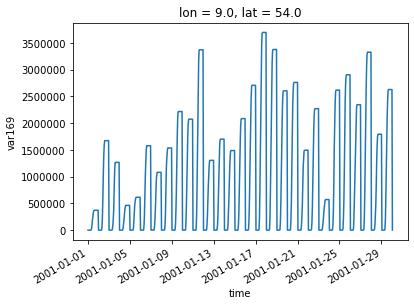

In [155]:
#make an example time line of the original radiation data
era5.var169.sel(time=slice(start_time,end_time),lon=lons,lat=lats).plot()

In [156]:
#transform to hourly instantaneoues values
GHI_in_j = era5.var169.sel(time=slice(start_time,end_time),lon=lons,lat=lats).diff("time", 1, label="upper")
#transform to W or Wh
ghi_era5l = (GHI_in_j.where(GHI_in_j > 0, 0))/3600
print(ghi_era5l)

<xarray.DataArray 'var169' (time: 696)>
dask.array<shape=(696,), dtype=float32, chunksize=(696,)>
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01T02:00:00 ... 2001-01-30T01:00:00
    lon      float64 9.0
    lat      float64 54.0


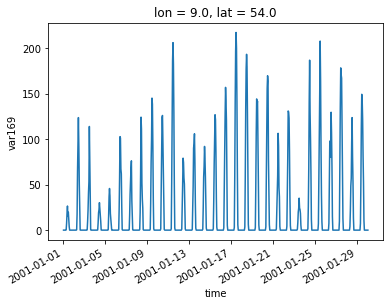

In [157]:
#plot the new GHI time series
ghi_era5l.plot()

## The second step is to calculate the DHI and DNI from GHI using the ERBS algorithm

In [158]:
timepre = ghi_era5l["time"].values
timeindex = pd.to_datetime(timepre, dayfirst=True, utc=True, infer_datetime_format=True)
dayofyear = ghi_era5l.time.dt.dayofyear.values
Zenith = pvlib.solarposition.get_solarposition(timepre, latitude=lats, longitude=lons).zenith.values
#plt.plot(Zenith)
erbs = pvlib.irradiance.erbs(ghi_era5l, zenith=Zenith, datetime_or_doy=dayofyear)
dni_era5l = erbs["dni"]
dhi_era5l = erbs["dhi"]

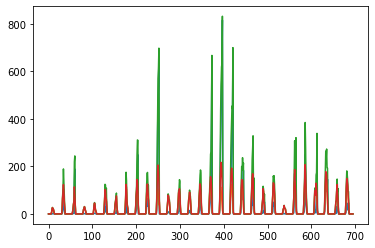

In [159]:
#plot the dni (blue)
plt.plot(dni_era5l)
#plot the dhi (orange)
plt.plot(dhi_era5l)
#plot the sum of the derived dni and dhi (green)
plt.plot(dni_era5l+dhi_era5l)
#plot the original ghi (red)
plt.plot(ghi_era5l)
#print(timeindex.values)

## The third step is to prepare the temperature and wind speed data

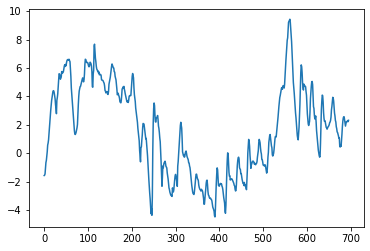

In [160]:
#read the temperature and transform to grad celcius
temperature_pre = (era5.var167.sel(time=slice(start_time,end_time),lon=lons,lat=lats))-273.15
temperature = temperature_pre[1:].values
plt.plot(temperature)

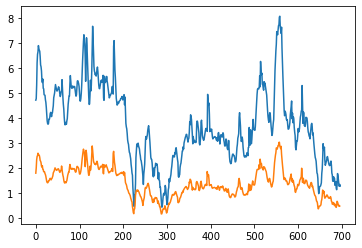

In [161]:
#read the wind data and transfrom to wind speed a one meter height
wind_speed_pre2 = (np.sqrt(((era5.var165.sel(time=slice(start_time,end_time),lon=lons,lat=lats))**2)+
             ((era5.var166.sel(time=slice(start_time,end_time),lon=lons,lat=lats))**2)))

#calculate the wind speed a at one meter height. A surface roughness length of 0.25 will be used. 
#This corresponds to High crops; scattered obstacles
wind_speed_pre1 = wind_speed_pre2 * ((np.log(1/0.25))/(np.log(10/0.25)))
wind_speed = wind_speed_pre1[1:].values
plt.plot(wind_speed_pre2)
plt.plot(wind_speed)

## The fourth step is to put all weather data in a single data frame

In [162]:
weather = pd.DataFrame({'ghi': ghi_era5l.values, 
                        'dni': dni_era5l, 
                        'dhi': dhi_era5l, 
                        'temp_air': temperature, 
                        'wind_speed': wind_speed},
                       index=timeindex)
#weather

## The fifth step is to load specifications from standard/declared modules and inverters

In [167]:
# load the module and inverter specifications
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
#the sandia modules have models for the years 2006-2014
#print(sandia_modules)
cec_modules = pvlib.pvsystem.retrieve_sam('cecMod')
#print(cec_modules)
#the cec modules have models for the years 2010-2015 but do not work with the wrapper
#it should not be that complicated to create an own database
# load the inverters
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
#print(cec_inverters)
#cec_module = cec_modules['iTek_iT_300_HE']
#print(cec_module)

sandia_module = sandia_modules['Silevo_Triex_U300_Black__2014_']
STC = 300
#print(sandia_module['Area'])
cec_inverter = cec_inverters['ABB__MICRO_0_3_I_OUTD_US_240_240V__CEC_2014_']

#print(cec_inverter['Paco'])
#check that the Paco is at least equal to the STC
#calculate the amount of panels that are necesary to complete 1kWp
number_of_panels_1kWp = 1000/STC
#calculate the area required for 1 kWp
area_1kWp = number_of_panels_1kWp * sandia_module['Area']
#print(number_of_panels_1kWp)
#print(area_1kWp)

### Define the system parameters and the model chain

In [177]:
system = PVSystem(surface_tilt=slope, surface_azimuth=aspect,
                  module_parameters=sandia_module,
                  inverter_parameters=cec_inverter)

mc = ModelChain(system, location)
print(mc)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temp_model: sapm_temp
  losses_model: no_extra_losses


## Finally, run the model and get the ac output of the system that has been simulated

/home/lramirez/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


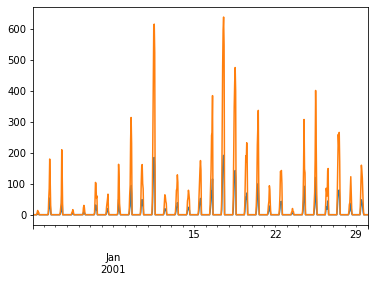

In [178]:
mc.run_model(times=weather.index, weather=weather)
#print(mc.ac)
mc.ac.plot()
pv_output = mc.ac * number_of_panels_1kWp * system_size
pv_output.plot()

#for the outputs have a look of https://pvlib-python.readthedocs.io/en/latest/modelchain.html

In [ ]:
#to dos:

#make a function out of it
#find an efficient way to concatenate multiple months of data... 


#completed important to dos
#check the calculation also using fdir 228021 =DNI -> this variable does not exist in the land data
#find the PV and inversors data bases -> the types can be find by printing the call of the data base
#test if the model also runs with the CEC modules data base -> it could but it would require additional parameters:
    #include dc_model='cec', aoi_model='no_loss' in model chain
    #and add the weather variable 'precipitable_water'



#further notes:
#separate the ssrd into direct and diffuse radiation 
 




In [166]:
import gc
gc.collect()

428